# 关于券商波动率预测 相关系数 0.7 这件事

有两篇barra多因子券商的文章，其中关于波动率预测与实际的值相关系数都 > 0.7

![vol_fz](resources/vol_fangzheng.png)

![vol_fz](resources/vol_huatai.png)


下面是我的结果，real是真实波动率（未来21天）。raw 表示我们之前的方法，直接用前面188天的波动率。factor 表示用因子分解，做EWM之后的结果

\begin{equation}
corr_{raw} = 0.152
\end{equation}

\begin{equation}
corr_{factor} = 0.3686
\end{equation}

用factor的预测，确实比直接要好，但是远远达不到券商的0.7

![vol_my](resources/vol_my.png)


尝试了文章中各种优化修正后，发现依然如此。我对比了下我们的图和券商的图，2012-2014年其实跟我们的差不多，为啥他们的相关系数可以到0.7 ？



### 抠图

把方正的图（数据点比较多）截屏，然后写了个程序，把里面数据点挖出来，方法很简单，就找里面红点和黄点就行了。程序如下，相关系数确实是 0.769

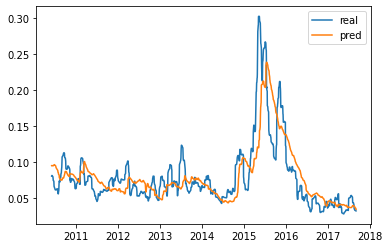

corr=0.769551551594551


In [13]:
import imageio.v2 as imageio
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from datetime import datetime

from ElephasReader import DataReader as dr
dr.__init__()

bgn, end = datetime(2010,6,2), datetime(2017,9,5)
dts = dr.get_trade_cal().set_index(['trade_date'])
dts = list(dts.loc[bgn:end].index)
ndt = len(dts)

im = imageio.imread('resources/bm.png')
R, C, D = im.shape


real, pred = [], []
for j in range(0, C, 1):
    for i in range(R):
        r, g, b = im[i][j]
        vol = 0.35 - i / R * 0.35
        dt = dts[int((j / C) * ndt)]
        if b / r < 0.5 and b / g < 0.5:
            if len(real) == 0 or real[-1][0] != dt:
                real.append([dt, vol])
        elif g / r < 0.5:
            if len(pred) == 0 or pred[-1][0] != dt:
                pred.append([dt, vol])

df_real = pd.DataFrame(data=real, columns=['date', 'vol']).set_index(['date'])
df_pred = pd.DataFrame(data=pred, columns=['date', 'vol']).set_index(['date'])

df = pd.DataFrame(index=df_real.index)
df['real'] = df_real['vol']
df['pred'] = df_pred['vol']
corr = df['real'].corr(df['pred'])

plt.plot(df['real'], label='real')
plt.plot(df['pred'], label='pred')
plt.legend()
plt.show()

print(f"corr={corr}")

df.to_pickle('ref.pkl')



### 分析方正的数据

2011-2017 这段数据，有明显的特征，14年中旬到17年中旬波动率有很大的一个峰值。分成三个时间段来看，峰值前，峰值，峰值后，分别计算correlation，结果如下


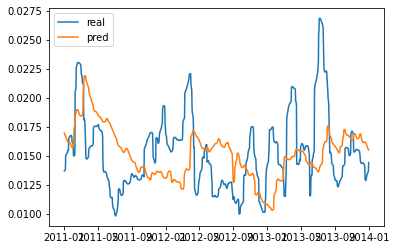

[2011-01-01-2014-01-01] corr=0.058892940633759355


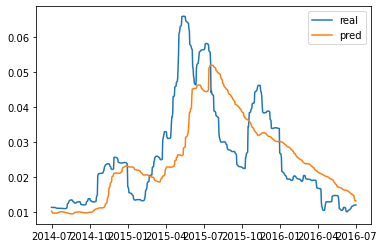

[2014-07-01-2016-07-01] corr=0.6816147499020287


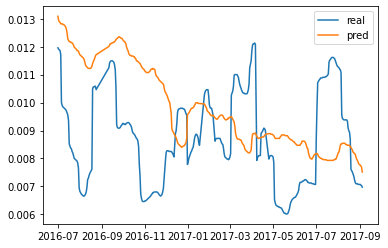

[2016-07-01-2017-09-04] corr=-0.02727565555772563


In [6]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

df0 = pd.read_pickle('ref.pkl')
df0['real'] = df0['real'] / (21**0.5)
df0['pred'] = df0['pred'] / (21**0.5)

bgn, end = datetime(2011,1,1), datetime(2014,7,1)
df = df0.loc[bgn:end]
plt.plot(df['real'], label='real')
plt.plot(df['pred'], label='pred')
plt.legend()
plt.show()
corr = df['real'].corr(df['pred'])
print(f"[{bgn.date()}-{end.date()}] corr={corr}")

bgn, end = datetime(2014,7,1), datetime(2016,7,1)
df = df0.loc[bgn:end]
plt.plot(df['real'], label='real')
plt.plot(df['pred'], label='pred')
plt.legend()
plt.show()
corr = df['real'].corr(df['pred'])
print(f"[{bgn.date()}-{end.date()}] corr={corr}")

bgn, end = datetime(2016,7,1), datetime(2017,9,4)
df = df0.loc[bgn:end]
plt.plot(df['real'], label='real')
plt.plot(df['pred'], label='pred')
plt.legend()
plt.show()
corr = df['real'].corr(df['pred'])
print(f"[{bgn.date()}-{end.date()}] corr={corr}")




结果很明显了，券商的correlation能到0.7，主要来自中间峰值部分的贡献，这一段是一个持续时间很长的大的趋势。预测值相对真实值，是有个delay的，这一段的相关系数比较高

### 一点推导

下面计算一个**对称的向上突出的波峰**，平移一段距离后，correlation的变化


\begin{equation}
\rho_{X,Y} = \frac{cov(X,Y)}{\sigma_X \sigma_Y}
\end{equation}


1. Y 是 X 的一个向右较小的平移。因为是平移，所以波动率和平均值都不变，即$\sigma_Y = \sigma_X$，$\mu_X = \mu_Y$

2. $cov(X,Y) = E[(X-\mu_X)(Y-\mu_Y)]$。因为是一个对称的波峰，对称轴左右是一样的，所以可以只取对称轴左边。而对称轴左边，$Y = \alpha X$。$\alpha$ 为某个比例系数，因为Y是向右平移，整体比X要低一些。因此，cov 就可以写为

\begin{equation}
\begin{aligned}
cov(X,Y) = E[(X-\mu_X)(\alpha X - \mu_X)] \\
= E[\alpha X^2 + \mu_X^2 - X\mu_X - \alpha X\mu_X] \\
= \alpha (E[X^2] - \mu_X^2) \\
= \alpha \sigma_X ^ 2
\end{aligned}
\end{equation}

所以相关系数就是

\begin{equation}
\begin{aligned}
\rho_{X,Y} = \frac{cov(X,Y)}{\sigma_X \sigma_Y} \\
= \frac{\alpha \sigma_X^2}{\sigma_X^2} \\
= \alpha
\end{aligned}
\end{equation}

因此，一个对称的波峰，向右平移一段距离之后的相关系数，相关系数就从1变为 $\alpha = \frac{X_{t-\delta}}{X_t}$

3. 回到方正的数据，计算下波峰开始前半段的$\alpha$，可见基本吻合。

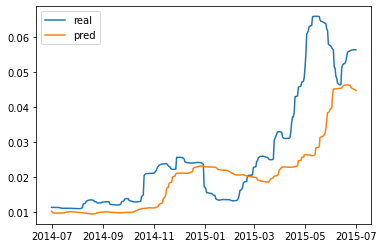

[2014-07-01-2015-07-01]
corr=0.8025372220386138
alpha=0.853307910644441


In [12]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

df0 = pd.read_pickle('ref.pkl')
df0['real'] = df0['real'] / (21**0.5)
df0['pred'] = df0['pred'] / (21**0.5)

bgn, end = datetime(2014,7,1), datetime(2015,7,1)
df = df0.loc[bgn:end]
plt.plot(df['real'], label='real')
plt.plot(df['pred'], label='pred')
plt.legend()
plt.show()
corr = df['real'].corr(df['pred'])
print(f"[{bgn.date()}-{end.date()}]")
print(f"corr={corr}")
print(f"alpha={(df['pred'] / df['real']).mean()}")